In [10]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# 0. Intro
1. 计算得到理论模型下对于target data的NLL值作为metric，方便对比
2. 人工数据集需要4列：GT1, GT2(SA), GT2(common)+GT2(NN)
3. 真实数据集需要4列：GT1, GT2(SA), GT2(common)+GT2(NN)
4. 计算方法都是先计算前3列再计算最后一列
# 1. Preparations
## 1.1 global settings

In [27]:
import pandas as pd
import numpy as np
import math
import random
import os
import pickle
from matplotlib import pyplot as plt
from tqdm import tqdm

# For GT-2
from GT_model.GT_2.SA_for_PT_funcs_delta_eq1 import *
import GT_model.GT_2.SA_for_PT_funcs_delta_eq1
# reload(GT_model.GT_2.SA_for_PT_funcs_delta_eq1)

from metric_for_GTs_func import *


## 1.2 the data path


In [70]:
ARTIFICIAL = True
noise_pct = 0.05           # 噪音占比:我们希望生成的data总体上最多浮动的百分比noise_pct
seed = 407            # [3,31,204,223,407]# 计算alpha和lambda的来源：NN的infer结果，还是来自csv的结果

# Target data
if ARTIFICIAL:
        target_path = "../data/artificial_targets_v2_" + "noise=" + str(noise_pct)
else:
        target_path = r"../data/targets_all"

# Input: GT-2 params
if ARTIFICIAL:
        # GT-2 NN 产生的params
        params_opitim_path_NN = r"../data/SA_PT/params_artificial_v2_noise=" + str(noise_pct)+"_seed=" + str(seed) + ".csv"
        # SA 的 params
        params_opitim_path_SA = "../data/SA_PT/params_opitim_artificial_v2_noise_"+str(noise_pct)+".csv"
else:
        # GT-2 NN 产生的params
        params_opitim_path_NN = r"../data/SA_PT/params_seed=" + str(seed) + ".csv"
        # SA 的 params
        params_opitim_path_SA = "../data/SA_PT/params_opitim_delta_T.csv"

# target data是target_5时 TARGET = 5
TARGET = 1

# Small dataset
small_settings_NN_path = r"../data/small_settings_NN.csv"
# Large data
large_settings_NN_path = r'E:\DATA\large_dta\large_settings_NN.csv'

# Output path
# 3 col and 4 col
if ARTIFICIAL:
        NLL_metric_path_1  = r"../data/GT_metric/NLL_metric_GT_Tgt=1_e30_artificial_v_2_noise="+str(noise_pct)+".csv"
        NLL_metric_path_2  ="../data/GT_metric/NLL_metric_GT_Tgt=1_e30_all_"+"artificial_targets_v2_" + "noise=" + str(noise_pct)+"_seed="+str(seed)+".csv"
else:
        NLL_metric_path_1  ="../data/GT_metric/NLL_metric_GT_Tgt=1_e30.csv"
        # 添加的这一列和seed有关！
        NLL_metric_path_2  ="../data/GT_metric/NLL_metric_GT_Tgt=1_e30_seed="+str(seed)+".csv"

col_names = ['GT1', 'GT2(common)','GT2(SA)']
col_names_NN = ['GT2(NN)']

# For GT-2
alpha = -0.013581112
delta = 1
labda = 3.312402533

MIN_LOSS = 1e-30


## 1.3 Read in

In [71]:
data_key_small = pd.read_csv(small_settings_NN_path,encoding="utf-8")
data_key_large = pd.read_csv(large_settings_NN_path,encoding="utf-8")

# target_path里有全部的target data地址
target_all_path = os.listdir(target_path)

# params_opitim_delta= pd.read_csv(params_opitim_delta_path,encoding="utf-8")
params_opitim_SA = pd.read_csv(params_opitim_path_SA,encoding="utf-8")

len_small = data_key_small.shape[0]
len_large = data_key_large.shape[0]
len_all = len(target_all_path)
print(f"小数据集有 *{len_small}* 场auction，大数据集有 *{len_large}* 场auction，一共*{len_all}*")


小数据集有 *1196* 场auction，大数据集有 *80* 场auction，一共*1276*


In [49]:
data_key_large.head()

,desc,bidincrement,bidfee,retail,flg_endprice
0,20 BIDS VOUCHER,0.01,0.01,14.0,0
1,20 BIDS VOUCHER,0.01,0.01,15.0,0
2,50 BIDS VOUCHER,0.01,0.01,35.0,0
3,50 FREEBIDS VOUCHER!,0.01,0.01,35.0,0
4,CLATRONIC PM 2658 HOT AIR POPCORN MAKER (WHITE),0.01,0.01,35.0,0


# 2. Compute the NLL
## 2.1 先算前3列
1. 注意真实数据集只跑一次就够了

In [50]:
params_opitim_SA.head()

,key_idx,alpha,delta,labda,initial_loss,final_loss,avg_loss
0,0,0.061227,1,4.007592,1048.245937,971.189029,3.034966
1,1,0.047061,1,7.664214,939.993322,804.370159,2.654687
2,2,0.080019,1,4.080966,1710.033256,1506.151280,2.789169
3,3,0.097774,1,5.198637,737.680055,589.685310,2.330772
4,4,0.021540,1,7.627588,1086.205018,1041.966627,3.020193


In [51]:
NLL_metric = np.array([0]*len(target_all_path)*3).reshape(-1,3)
NLL_metric_pd = pd.DataFrame(NLL_metric,columns=col_names)

for i in tqdm(range(len_all)):
# for i in range(10):
        # Get target data
        target_path_i_path = os.path.join(target_path, target_all_path[i])
        target_df = pd.read_csv(target_path_i_path,encoding="utf-8")
        target = list(target_df.iloc[:,0])
        idx = 0
        # Get the auction setting
        if i < len_small:
                idx = i
                settings_df = data_key_small.iloc[idx,:]
        else:
                idx = i-len_small
                settings_df = data_key_large.iloc[idx,:]
        # Compute the NLL value of each GT models
        NLL_metric_pd.iloc[i,0] = GT_1(settings_df,target)
        # GT-2: common
        NLL_metric_pd.iloc[i,1] = GT_2(settings_df,target)

        # GT-2: SA
        alpha_i = params_opitim_SA.loc[i,'alpha'].item()
        labda_i = params_opitim_SA.loc[i,'labda'].item()
        NLL_metric_pd.iloc[i,2] = GT_2_uniq(settings_df,target,alpha_i,labda_i)

100%|██████████| 1276/1276 [14:31<00:00,  1.46it/s]


In [53]:
NLL_metric_path_1

'../data/GT_metric/NLL_metric_GT_Tgt=1_e30_artificial_v_2_noise=0.05.csv'

In [54]:
NLL_metric_pd.to_csv(NLL_metric_path_1,encoding="utf-8",header=True,index=False)
NLL_metric_pd.head()

,GT1,GT2(common),GT2(SA)
0,6.510921,10.116069,3.034966
1,5.440194,5.569359,2.654687
2,6.002648,7.397694,2.789169
3,4.807790,4.285982,2.330772
4,4.454099,3.796559,3.020193


In [39]:
NLL_metric_pd.mean()

GT1            6.142750
GT2(common)    7.320263
GT2(SA)        6.417691
dtype: float64

## 2.2 根据random seed计算部分metric [optional]

In [55]:
NLL_metric_all = pd.read_csv(NLL_metric_path_1,encoding="utf-8")
NLL_metric_all.head()

,GT1,GT2(common),GT2(SA)
0,6.510921,10.116069,3.034966
1,5.440194,5.569359,2.654687
2,6.002648,7.397694,2.789169
3,4.807790,4.285982,2.330772
4,4.454099,3.796559,3.020193


In [56]:

def setup_seed(seed):
        """
        Set seed
        Args:
        seed:
        """
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True

train_pct = 0.7
vali_pct = 0.2
test_pct = 0.1

def seed2_test_idx(seed):

        setup_seed(seed)

        shuffled_indices = np.random.permutation(len_all)
        train_idx = shuffled_indices[:int(train_pct * len_all)]
        tmp = int((train_pct + vali_pct) * len_all)
        val_idx = shuffled_indices[int(train_pct * len_all):tmp]
        test_idx = shuffled_indices[tmp:]

        return test_idx

- 只取test set上的metric做比较

In [57]:
NLL_metric_test_pd = pd.DataFrame()
for i in range(400,420):
        test_idx = seed2_test_idx(i)
        NLL_metric_test = NLL_metric_all.iloc[test_idx,:].mean()
        NLL_metric_test.columns = [str(i)]
        NLL_metric_test_pd = pd.concat([NLL_metric_test_pd,NLL_metric_test],axis=1,ignore_index=True)
NLL_metric_test_pd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GT1,5.883374,5.666227,6.202299,6.127058,6.182548,6.147268,5.968057,6.175018,6.380398,6.093821,5.905741,5.841440,6.185187,5.738962,5.930806,5.989298,5.804795,6.281691,5.813772,6.032700
GT2(common),6.819498,6.354654,7.277116,7.275202,7.305540,7.374980,7.075862,7.413813,7.841595,7.416052,7.204366,6.764744,7.356624,6.548365,7.514830,6.860478,6.847741,7.955465,6.567041,7.341943
GT2(SA),5.978948,5.874476,6.500927,6.406702,6.711144,6.917933,6.258685,6.760955,7.354463,6.330880,6.198600,5.849018,6.512822,5.717968,6.748747,6.102427,5.843371,7.259156,5.802198,6.721192


## 2.3 再算NN这一列
1. 节省时间，可以直接算这一列，然后和上面的拼接
2. random seed不影响上面的值

In [33]:
params_opitim_NN = pd.read_csv(params_opitim_path_NN,encoding="utf-8")
NLL_metric_all = pd.read_csv(NLL_metric_path_1,encoding="utf-8")
params_opitim_path_NN

'../data/SA_PT/params_artificial_v2_noise=0.05_seed=31.csv'

In [34]:
NLL_metric_NN = np.array([0]*len(target_all_path)*1).reshape(-1,1)
NLL_metric_NN_pd = pd.DataFrame(NLL_metric_NN,columns=col_names_NN)

for i in tqdm(range(len_all)):
# for i in range(10):
        # Get target data
        target_path_i_path = os.path.join(target_path, target_all_path[i])
        target_df = pd.read_csv(target_path_i_path,encoding="utf-8")
        target = list(target_df.iloc[:,0])
        idx = 0
        # Get the auction setting
        if i < len_small:
                idx = i
                settings_df = data_key_small.iloc[idx,:]
        else:
                idx = i-len_small
                settings_df = data_key_large.iloc[idx,:]

        # GT-2: NN
        alpha_i = params_opitim_NN.loc[i,'alpha'].item()
        labda_i = params_opitim_NN.loc[i,'labda'].item()
        NLL_metric_NN_pd.iloc[i,0] = GT_2_uniq(settings_df,target,alpha_i,labda_i)

100%|██████████| 1276/1276 [04:15<00:00,  5.00it/s]


- 合并两个表

In [35]:
NLL_metric_all[col_names_NN[0]] = NLL_metric_NN_pd.iloc[:,0]
NLL_metric_all.head()

,GT1,GT2(common),GT2(SA),GT2(NN)
0,6.511353,10.113840,3.105446,3.429143
1,5.440389,5.569214,2.680497,2.793203
2,6.002874,7.397112,2.815074,2.992014
3,4.812571,4.294273,2.377858,2.514237
4,4.463451,3.819465,3.140084,3.087075


In [36]:
NLL_metric_all.mean()

GT1            6.142750
GT2(common)    7.320263
GT2(SA)        6.417691
GT2(NN)        5.378669
dtype: float64

In [37]:
NLL_metric_path_2

'../data/GT_metric/NLL_metric_GT_Tgt=1_e30_all_artificial_targets_v2_noise=0.05_seed=31.csv'

In [38]:
NLL_metric_all.to_csv(NLL_metric_path_2,encoding="utf-8",header=True,index=False)

In [72]:
# NLL_metric_all = pd.read_csv(NLL_metric_path_1,encoding="utf-8")
# NLL_metric_NN_pd = pd.read_csv(NLL_metric_path_2,encoding="utf-8")
# NLL_metric_all[col_names_NN[0]] = NLL_metric_NN_pd.iloc[:,0]
# NLL_metric_all.head()
# NLL_metric_all.to_csv(NLL_metric_path_2,encoding="utf-8",header=True,index=False)

# 5. 分析

In [111]:
# 提取training set上的metric
def save_data_idx(LEN):
        """
        因为objective function会被执行很多次，所以这里先保存一下idx，使得所有objective在同一组dataset上进行。
        然后在tuning时，会在shuffle_time组不同的dataset split上进行，用以取平均
        Args:
        dataset:
        opt:
        shuffle_time: The num of list of index to be generated.
        """
        shuffled_indices = np.random.permutation(LEN)

        return shuffled_indices

def get_data_idx(shuffled_indices):
        """
        To get data split idx according to shuffled 'shuffled_indices'
        Args:
        shuffled_indices:
        opt:

        Returns:
        """

        DATA_len = len(shuffled_indices)

        train_idx = shuffled_indices[:int(0.7 * DATA_len)]
        tmp = int((0.7 + 0.2) * DATA_len)
        val_idx = shuffled_indices[int(0.7 * DATA_len):tmp]
        test_idx = shuffled_indices[tmp:]

        return train_idx,val_idx,test_idx

shuffled_indices = save_data_idx(len_all)
train_idx,val_idx,test_idx = get_data_idx(shuffled_indices)

# 计算train_idx的metric
NLL_train = NLL_metric_pd.iloc[train_idx,:]
NLL_train.mean()

nll1    6.844739
nll2    8.006883
nll3    6.762404
dtype: float64

In [19]:
NLL_metric_pd = pd.read_csv(NLL_metric_path,encoding="utf-8")
NLL_metric_pd.head()

,nll1,nll2,nll3,diff_1_3,diff_1_2
0,7.274325,8.422152,59.208116,-51.933791,-1.147827
1,5.895485,6.095491,10.023283,-4.127798,-0.200006
2,7.044588,7.095199,10.661947,-3.617359,-0.050611
3,57.089958,58.632186,69.077553,-11.987595,-1.542229
4,5.480635,5.635930,6.708339,-1.227704,-0.155295


In [153]:
NLL_metric_pd.mean()

nll1        6.053707
nll2        7.311598
nll3        6.018353
diff_1_3    0.035354
diff_1_2   -1.257891
dtype: float64

In [151]:
NLL_metric_pd['diff_1_3'] = NLL_metric_pd.nll1 - NLL_metric_pd.nll3
print(f"GT-1 优于 GT-2(uniq params) 的次数：{len(NLL_metric_pd[NLL_metric_pd.diff_1_3<0])}")


GT-1 优于 GT-2(uniq params) 的次数：651


In [152]:
NLL_metric_pd['diff_1_2'] = NLL_metric_pd.nll1-NLL_metric_pd.nll2
print(f"GT-1 优于 GT-2(common params) 的次数：{len(NLL_metric_pd[NLL_metric_pd.diff_1_2<0])}")


GT-1 优于 GT-2(common params) 的次数：810


- 取出GT-2(uniq params)表现较好的index

In [46]:
idx_GT2_better = NLL_metric_pd.loc[NLL_metric_pd.diff_1_3>0].index.tolist()

# Save the object to a file using pickle
with open('idx_GT2_better.pickle', 'wb') as f:
        pickle.dump(idx_GT2_better, f)

In [38]:
GT2_better_GT1 = NLL_metric_pd[NLL_metric_pd.diff_1_2>0].copy()
GT2_better_GT1

,nll1,nll2,nll3,diff_1_3,diff_1_2
5,4.782111,4.604050,4.596256,0.185856,0.178062
10,4.424717,4.367903,4.263774,0.160943,0.056813
48,4.490065,4.214732,4.263987,0.226078,0.275333
57,6.652434,6.617769,6.776412,-0.123978,0.034665
62,5.277681,5.138671,5.580647,-0.302966,0.139010
...,...,...,...,...,...
1229,8.160232,7.336610,6.871275,1.288958,0.823623
1230,8.160232,7.222429,5.743403,2.416829,0.937804
1231,8.682538,7.928424,6.810318,1.872220,0.754114
1232,8.987072,8.382943,6.047435,2.939636,0.604129


# 5. test
## 5.1 MINloss test
1. 读取不同MINLoss下的metric，看一下MINLoss对于结果有无影响
2. plot: 横轴MINLoss，纵轴metric

In [18]:
metric_list = [2,4,6,8,10,12,20,30,40]

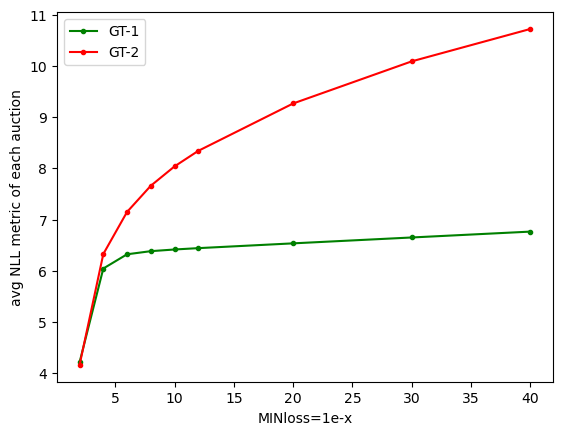

In [19]:
metric = np.array([0]*len(metric_list)*2).reshape(-1,2)
metric_pd = pd.DataFrame(metric)

for i in range(len(metric_list)):
        file_head = "../data/GT_metric/NLL_metric_GT_Tgt=1_e"
        file_end = ".csv"

        file_name = file_head + str(metric_list[i]) + file_end

        data = pd.read_csv(file_name,encoding="utf-8")
        metric_i = np.array(data.sum(axis=0))

        metric_pd.iloc[i,0] = metric_i[0]
        metric_pd.iloc[i,1] = metric_i[1]

metric_pd = metric_pd/ len(target_all_path)
plt.plot(metric_list, metric_pd.iloc[:,0], color='green', marker = ".", label='GT-1')
plt.plot(metric_list, metric_pd.iloc[:,1], color='red', marker = ".", label='GT-2')

plt.xlabel('MINloss=1e-x')
plt.ylabel('avg NLL metric of each auction')
plt.legend()
plt.show()